<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Minutes-and-Statements" data-toc-modified-id="Minutes-and-Statements-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Minutes and Statements</a></span></li><li><span><a href="#Measuring-the-Distance" data-toc-modified-id="Measuring-the-Distance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Measuring the Distance</a></span></li><li><span><a href="#Methodology" data-toc-modified-id="Methodology-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Methodology</a></span><ul class="toc-item"><li><span><a href="#LDA-Topic-Modeling" data-toc-modified-id="LDA-Topic-Modeling-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LDA Topic Modeling</a></span></li><li><span><a href="#Sentiment-analysis" data-toc-modified-id="Sentiment-analysis-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Sentiment analysis</a></span></li><li><span><a href="#Traing-signal-contained-in-minutes" data-toc-modified-id="Traing-signal-contained-in-minutes-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Traing signal contained in minutes</a></span></li></ul></li><li><span><a href="#Conclusion-and-Further-work" data-toc-modified-id="Conclusion-and-Further-work-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusion and Further work</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

# Trading signal contained in FOMC files

In [1]:
import re
from collections import Counter
from os import listdir

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import spacy
import swifter
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
from nltk.tokenize import word_tokenize
# nltk.download('punkt')

d:\software\python\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
d:\software\python\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
d:\software\python\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
d:\software\python\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


## Minutes and Statements

After each meeting, the FOMC releases to the public a statement regarding its policy decision. The minutes of each regularly scheduled meeting of the Committee provide a timely summary of significant policy issues addressed by meeting participants. The minutes go back to 1936, but we found that it is not very informative, and it was not public until 1967, so ignored.

> "From 1936 through May 1967, the FOMC maintained for its use extensive "minutes," which were detailed records of attendance, discussions, and decisions at its meetings. " -- the FOMC official website. 

> "The Minutes of Actions, first released in 1967, were designed to provide this information. They were made available to the public on the same schedule as the Record of Policy Actions." -- the FOMC official website. 

After 1967, the minutes began public but varied from the recent minutes much. The current format of meeting minutes starts from 1993.

> "From their emergence in their present form in February 1993 until December 2004, the minutes were published approximately three days after the Committee's subsequent meeting. In December 2004, the Committee decided to expedite the release of its minutes. Since then, the minutes have been made available to the public three weeks after the date of the policy decision, thus reducing the lag in their release by an average of about three weeks." -- the FOMC official website. 

One year later, in February 1994, the FOMC first announced the outcome of a meeting, so the period of our dataset ranges from 1994-present.

> "After making several further post-meeting statements in 1994, the Committee formally announced in February 1995 that all changes in the stance of monetary policy would be immediately communicated to the public. In January 2000, the Committee announced that it would issue a statement following each regularly scheduled meeting, regardless of whether there had been a change in monetary policy." -- the FOMC official website. 

However, during hand-collecting the data from the FOMC's official website. We notice there is some inconsistency between minutes and statements. For example, on March 30, 1999, minutes were available, yet statements were not. After omitting these kind of imbalanced samples, we got 192 pairs of observations in total.
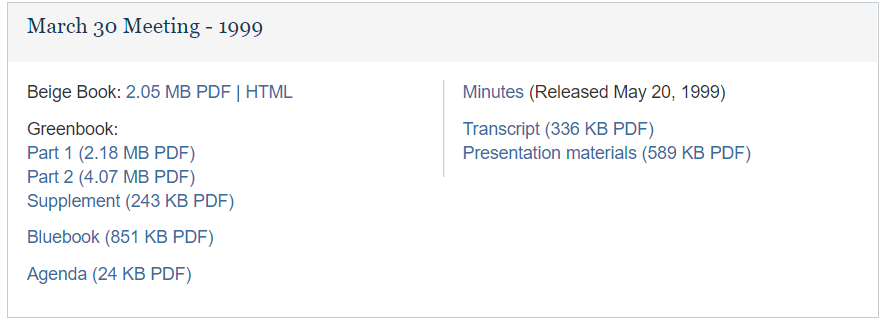

Furthermore, because present minutes comprise about ten parts, we only select the parts possibly containing "sentiment" narrative or discussion rather than objectively generated. Thus, we skip the first two and last three elements. Also, we ignore the citation of the statement included in the "Committee Policy Action" part.

- <font color=gray> Action to Adopt Changes to the Committee's Rules Regarding Availability of Information 
- <font color=gray> Developments in Financial Markets and Open Market Operations
- Staff Review of the Economic Situation
- Staff Review of the Financial Situation
- Staff Economic Outlook
- Participants' Views on Current Conditions and the Economic Outlook
- Committee Policy Action
- <font color=gray> Voting for this action
- <font color=gray> Voting against this action
- <font color=gray> Notation Vote

In [2]:
dates_statements, dates_minutes = [], []
with open('data\calendars_statements.txt', 'r') as f:
    for line in f.readlines():
        line = line.replace('\n', '')
        dates_statements.append(pd.to_datetime(line))
with open('data\calendars_minutes.txt', 'r') as f:
    for line in f.readlines():
        line = line.replace('\n', '')
        dates_minutes.append(pd.to_datetime(line))
dates_minutes = pd.DataFrame(dates_minutes)
dates_statements = pd.DataFrame(dates_statements)
dates_minutes, dates_statements

(             0
 0   1994-02-04
 1   1994-03-22
 2   1994-05-17
 3   1994-07-06
 4   1994-08-16
 ..         ...
 217 2021-03-17
 218 2021-04-28
 219 2021-06-16
 220 2021-07-28
 221 2021-09-22
 
 [222 rows x 1 columns],
              0
 0   1994-02-04
 1   1994-03-22
 2   1994-05-17
 3   1994-08-16
 4   1994-11-15
 ..         ...
 187 2021-03-17
 188 2021-04-28
 189 2021-06-16
 190 2021-07-28
 191 2021-09-22
 
 [192 rows x 1 columns])

In [3]:
minutes = []
with open('data\calendars_statements.txt', 'r') as f:
    for line in f.readlines():
        line = line.replace('\n', '')
        with open(r'data/minutes/FOMC_' + line + r'.txt', encoding='utf8', errors='ignore') as g:
            m = g.read().replace('\n', ' ').replace('\xad', '')
            minutes.append(m)
minutes = pd.DataFrame(minutes, columns=["minutes"])
minutes

,minutes
0,The information reviewed at this meeting indic...
1,The information reviewed at this meeting indic...
2,The information reviewed at this meeting sugge...
3,The information reviewed at this meeting sugge...
4,The information reviewed at this meeting sugge...
...,...
187,Staff Review of the Economic Situation The COV...
188,Staff Review of the Economic Situation The COV...
189,Staff Review of the Economic Situation The inf...
190,Staff Review of the Economic Situation The inf...


In [4]:
statements = []
with open('data\calendars_statements.txt', 'r') as f:
    for line in f.readlines():
        line = line.replace('\n', '')
        with open(r'data/statements/' + line + r'.txt', encoding='utf8', errors='ignore') as g:
            s = g.read().replace('\n', '').replace('\\xad', '')
            statements.append(s)
statements = pd.DataFrame(statements, columns=["statements"])
statements

,statements
0,Chairman Alan Greenspan announced today that t...
1,Chairman Alan Greenspan announced today that t...
2,The Federal Reserve today announced two action...
3,The Federal Reserve announced today the follow...
4,The Federal Reserve Board today approved an in...
...,...
187,The Federal Reserve is committed to using its ...
188,The Federal Reserve is committed to using its ...
189,The Federal Reserve is committed to using its ...
190,The Federal Reserve is committed to using its ...


In [5]:
df_minutes = pd.concat([dates_statements, minutes], axis=1)
df_minutes.columns = ['date', 'minutes']
df_minutes.head()

,date,minutes
0,1994-02-04,The information reviewed at this meeting indic...
1,1994-03-22,The information reviewed at this meeting indic...
2,1994-05-17,The information reviewed at this meeting sugge...
3,1994-08-16,The information reviewed at this meeting sugge...
4,1994-11-15,The information reviewed at this meeting sugge...


In [6]:
df_statements = pd.concat([dates_statements, statements], axis=1)
df_statements.columns = ['date', 'statements']
df_statements.head()

,date,statements
0,1994-02-04,Chairman Alan Greenspan announced today that t...
1,1994-03-22,Chairman Alan Greenspan announced today that t...
2,1994-05-17,The Federal Reserve today announced two action...
3,1994-08-16,The Federal Reserve announced today the follow...
4,1994-11-15,The Federal Reserve Board today approved an in...


In [7]:
df_minutes["number of words"] = df_minutes["minutes"].swifter.apply(lambda x: sum(len(y.split()) for y in x.split('.')))
df_minutes["number of sentences"] = df_minutes["minutes"].swifter.apply(lambda x: len(x.split('.')))

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

In [8]:
df_statements["number of words"] = df_statements["statements"].swifter.apply(
    lambda x: sum(len(y.split()) for y in x.split('.')))
df_statements["number of sentences"] = df_statements["statements"].swifter.apply(lambda x: len(x.split('.')))

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

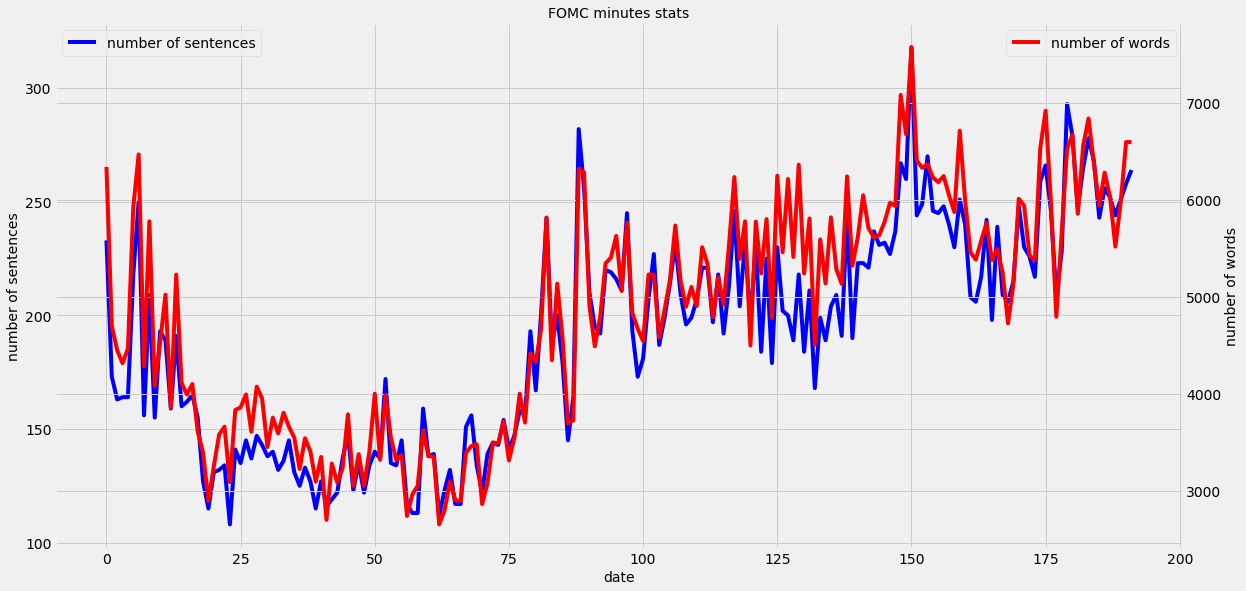

In [11]:
plt.rcParams["figure.figsize"] = (18, 9)
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(df_minutes.index, df_minutes["number of sentences"], 'b', label='number of sentences')
ax2.plot(df_minutes.index, df_minutes["number of words"], 'r', label='number of words')
plt.title('FOMC minutes stats', size='medium')
ax.legend(loc=2)
ax2.legend(loc=1)
ax.set_ylabel("number of sentences", size='medium')
ax2.set_ylabel("number of words", size='medium')
ax.set_xlabel("date", size='medium')
plt.show()

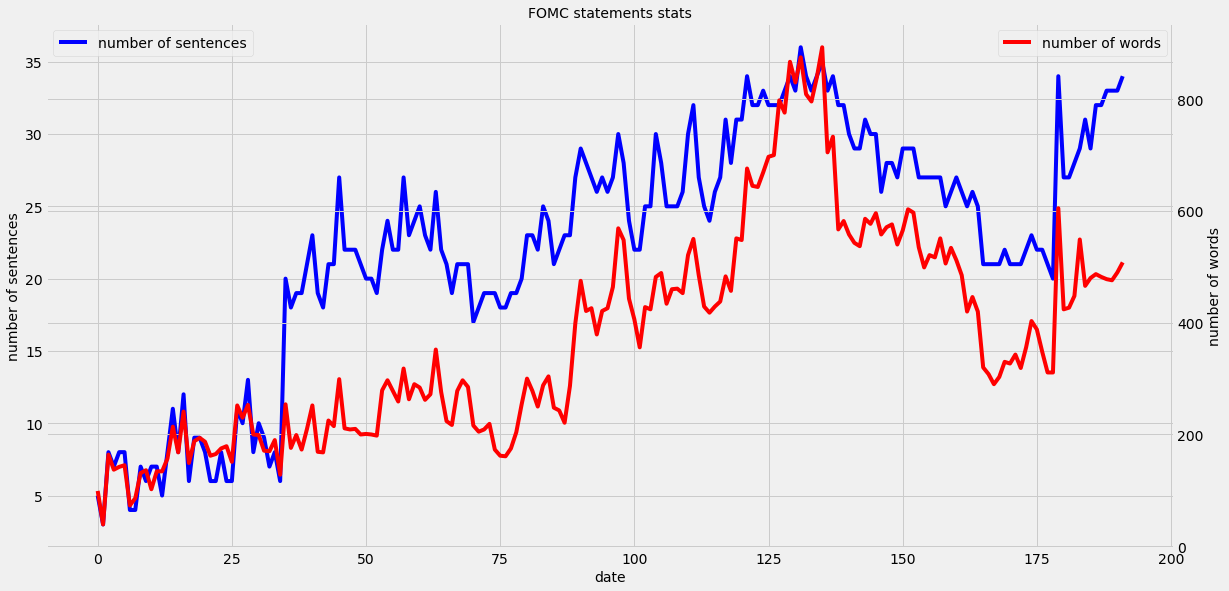

In [12]:
plt.rcParams["figure.figsize"] = (18, 9)
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
ax.plot(df_statements.index, df_statements["number of sentences"], 'b', label='number of sentences')
ax2 = ax.twinx()
ax2.plot(df_statements.index, df_statements["number of words"], 'r', label='number of words')
plt.title('FOMC statements stats', size='medium')
ax.legend(loc=2)
ax2.legend(loc=1)
ax.set_ylabel("number of sentences", size='medium')
ax2.set_ylabel("number of words", size='medium')
ax.set_xlabel("date", size='medium')
plt.show()

As we can see, the Fed has become very wordy over time, especially after the subprime crisis in 2008 and the COVID-19 shock in 2020. We also notice the length of minutes and statements were not growing at the same time. Then we use an industrial-strength natural language package `spacy` to compare the narrative between them.

In [13]:
nlp = spacy.load("en_core_web_sm")
all_stopwords = nlp.Defaults.stop_words
all_stopwords |= {'the', 'is', 'th', 's', 'm', 'would'}

In [14]:
def my_tokenizer(doc):
    text = word_tokenize(doc)
    tokens_without_sw = [word for word in text if not word in all_stopwords]

    return tokens_without_sw

In [15]:
def preprocess_tokens(tokens):
    '''
    Remove any extra lines, non-letter characters, and blank quotes
    '''
    remove_new_lines = [re.sub('\s+', '', token) for token in tokens]
    #Remove non letter characters
    non_letters = [re.sub('[^a-zA-Z]', '', remove_new_line) for remove_new_line in remove_new_lines]
    #Remove distracting single quotes
    remove_quotes = [re.sub("\'", '', non_letter) for non_letter in non_letters]
    #Removes empty strings from a list of strings
    final = list(filter(None, remove_quotes))

    return final

In [16]:
def get_words(full_text):
    raw = [word.lower() for word in full_text.split()]

    values = ','.join(map(str, raw))  #converts bytes object to string
    tokenizer = my_tokenizer(values)

    words = preprocess_tokens(tokenizer)
    # remove stopwords
    stops = nltk.corpus.stopwords.words('english')
    new_stopwords = ['chairman', 'would', 'mr']
    stops.extend(new_stopwords)
    words = [word for word in words if word not in stops]
    counter = Counter()
    counter.update(words)
    most_common = counter.most_common(25)

    return words, most_common

In [17]:
df_minutes["all_words_minutes"] = df_minutes["minutes"].swifter.apply(lambda x: get_words(x)[0])
df_minutes["top_tokens"] = df_minutes["minutes"].swifter.apply(lambda x: get_words(x)[1])
df_minutes

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

,date,minutes,number of words,number of sentences,all_words_minutes,top_tokens
0,1994-02-04,The information reviewed at this meeting indic...,6338,233,"[information, reviewed, meeting, indicated, ec...","[(growth, 56), (committee, 47), (economic, 40)..."
1,1994-03-22,The information reviewed at this meeting indic...,4699,173,"[information, reviewed, meeting, indicated, ec...","[(policy, 35), (members, 35), (february, 33), ..."
2,1994-05-17,The information reviewed at this meeting sugge...,4450,163,"[information, reviewed, meeting, suggested, ec...","[(growth, 29), (april, 27), (prices, 25), (pol..."
3,1994-08-16,The information reviewed at this meeting sugge...,4316,164,"[information, reviewed, meeting, suggested, pa...","[(growth, 38), (july, 26), (quarter, 26), (mem..."
4,1994-11-15,The information reviewed at this meeting sugge...,4467,164,"[information, reviewed, meeting, suggested, gr...","[(growth, 33), (policy, 26), (business, 24), (..."
...,...,...,...,...,...,...
187,2021-03-17,Staff Review of the Economic Situation The COV...,6033,252,"[staff, review, economic, situation, covid, pa...","[(participants, 54), (inflation, 51), (january..."
188,2021-04-28,Staff Review of the Economic Situation The COV...,5518,244,"[staff, review, economic, situation, covid, pa...","[(participants, 51), (inflation, 44), (remaine..."
189,2021-06-16,Staff Review of the Economic Situation The inf...,5978,251,"[staff, review, economic, situation, informati...","[(inflation, 65), (participants, 65), (economi..."
190,2021-07-28,Staff Review of the Economic Situation The inf...,6595,258,"[staff, review, economic, situation, informati...","[(inflation, 67), (participants, 63), (remaine..."


In [18]:
df_statements["all_words_statements"] = df_statements["statements"].swifter.apply(lambda x: get_words(x)[0])
df_statements["top_tokens"] = df_statements["statements"].swifter.apply(lambda x: get_words(x)[1])
df_statements

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

,date,statements,number of words,number of sentences,all_words_statements,top_tokens
0,1994-02-04,Chairman Alan Greenspan announced today that t...,99,5,"[alan, greenspan, announced, today, federal, o...","[(market, 3), (committee, 3), (greenspan, 2), ..."
1,1994-03-22,Chairman Alan Greenspan announced today that t...,39,3,"[alan, greenspan, announced, today, federal, o...","[(market, 2), (increase, 2), (alan, 1), (green..."
2,1994-05-17,The Federal Reserve today announced two action...,164,8,"[federal, reserve, today, announced, actions, ...","[(federal, 5), (reserve, 5), (discount, 3), (r..."
3,1994-08-16,The Federal Reserve announced today the follow...,137,7,"[federal, reserve, announced, today, following...","[(federal, 4), (reserve, 4), (actions, 3), (ec..."
4,1994-11-15,The Federal Reserve Board today approved an in...,142,8,"[federal, reserve, board, today, approved, inc...","[(federal, 5), (reserve, 5), (rate, 5), (disco..."
...,...,...,...,...,...,...
187,2021-03-17,The Federal Reserve is committed to using its ...,482,32,"[federal, reserve, committed, range, tools, su...","[(inflation, 10), (committee, 10), (percent, 8..."
188,2021-04-28,The Federal Reserve is committed to using its ...,478,33,"[federal, reserve, committed, range, tools, su...","[(committee, 10), (inflation, 9), (percent, 7)..."
189,2021-06-16,The Federal Reserve is committed to using its ...,476,33,"[federal, reserve, committed, range, tools, su...","[(committee, 10), (inflation, 9), (percent, 7)..."
190,2021-07-28,The Federal Reserve is committed to using its ...,490,33,"[federal, reserve, committed, range, tools, su...","[(committee, 11), (inflation, 9), (percent, 7)..."


In [19]:
#Count the total word frequency of statements
word_df_statements = pd.DataFrame(columns=['Words', 'Count'])
for i in range(len(df_statements)):  #total links
    word_count = {'Words': [], 'Count': []}
    for sets in df_statements['top_tokens'][i]:
        # print(files)  #total pairs
        word_count['Words'].append(sets[0])  #total words broken out
        word_count['Count'].append(sets[1])  #total count per word    
    word_df1_statements = pd.DataFrame(word_count)
    word_df_statements = word_df_statements.append(word_df1_statements, ignore_index=True)

total_words_statements = word_df_statements.groupby(['Words']).sum()
sorted_top_words_statements = total_words_statements.sort_values(by='Count', ascending=False)
sorted_top_words_1 = sorted_top_words_statements[:25]
sorted_top_words_1

,Count
Words,
committee,1435
inflation,1102
economic,778
federal,771
rate,667
market,609
policy,545
percent,434
conditions,390


In [20]:
#Count the total word frequency of minutes
word_df_minutes = pd.DataFrame(columns=['Words', 'Count'])
for i in range(len(df_minutes)):  #total links
    word_count = {'Words': [], 'Count': []}
    for sets in df_minutes['top_tokens'][i]:
        # print(files)  #total pairs
        word_count['Words'].append(sets[0])  #total words broken out
        word_count['Count'].append(sets[1])  #total count per word    
    word_df1_minutes = pd.DataFrame(word_count)
    word_df_minutes = word_df_minutes.append(word_df1_minutes, ignore_index=True)

total_words_minutes = word_df_minutes.groupby(['Words']).sum()
sorted_top_words_minutes = total_words_minutes.sort_values(by='Count', ascending=False)
sorted_top_words_2 = sorted_top_words_minutes[:25]
sorted_top_words_2

,Count
Words,
inflation,6957
economic,5844
participants,4903
rate,4605
growth,4273
prices,3694
committee,3684
market,3679
policy,3319


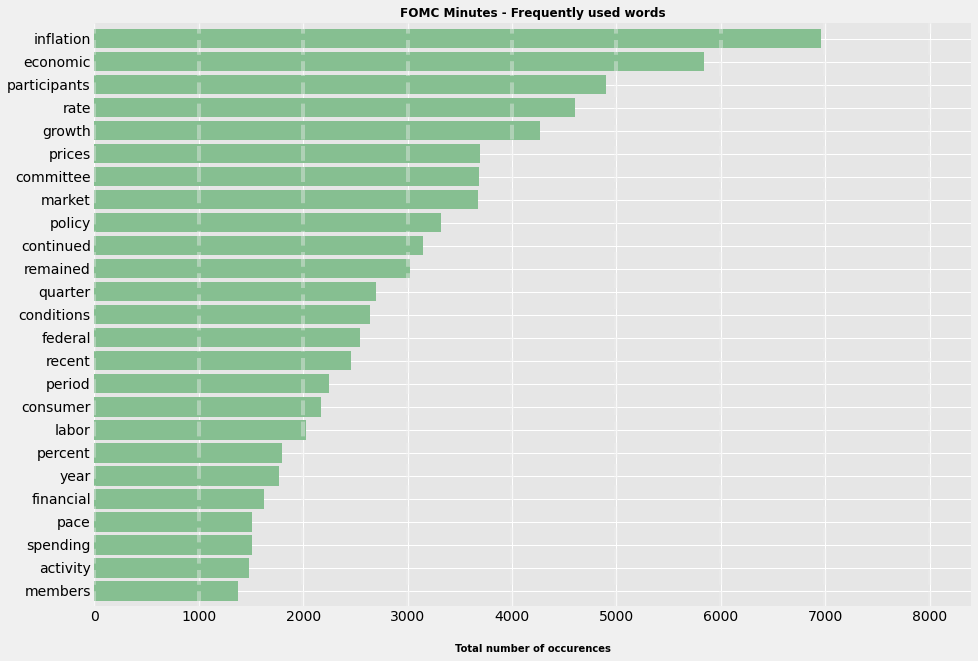

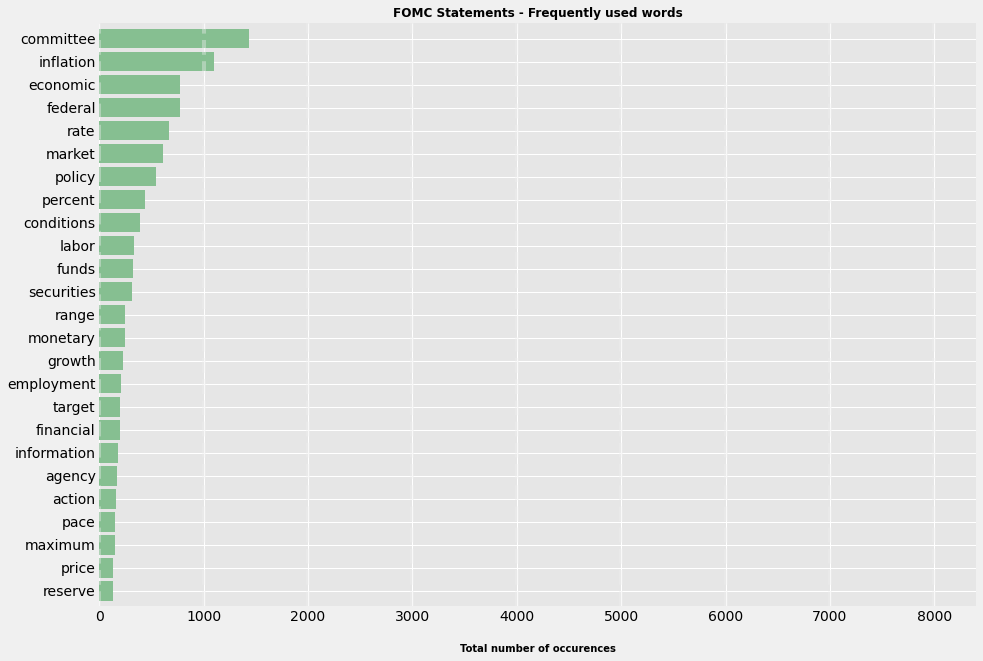

In [21]:
sorted_top_words_1 = sorted_top_words_1.sort_values(by="Count")
sorted_top_words_2 = sorted_top_words_2.sort_values(by="Count")

plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')

ax1 = sorted_top_words_2.plot(kind='barh', figsize=(14, 10), color='#86bf91', width=0.85)

ax1.get_legend().remove()
plt.title("FOMC Minutes - Frequently used words", fontsize=12, weight='bold')
# Draw vertical axis lines
vals = ax1.get_xticks()
for tick in vals:
    ax1.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set axis labels
ax1.yaxis.label.set_visible(False)
ax1.set_xlabel("Total number of occurences", labelpad=20, weight='bold', size=10)

ax2 = sorted_top_words_1.plot(kind='barh', figsize=(14, 10), color='#86bf91', width=0.85)

ax2.get_legend().remove()
plt.title("FOMC Statements - Frequently used words", fontsize=12, weight='bold')
# Draw vertical axis lines
# vals = ax2.get_xticks()
for tick in vals:
    ax2.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set axis labels
ax2.yaxis.label.set_visible(False)
ax2.set_xlabel("Total number of occurences", labelpad=20, weight='bold', size=10)

ax1.get_shared_x_axes().join(ax1, ax2)

We find both minutes and statements highlight inflation because the FOMC is in charge of two important goals. The first is to keep inflation at a target rate (2%). The second is to maximize the employment rate while the attention to the labor market of the two documents slightly differs. We will measure the distance between minutes and statements in the following section.

## Measuring the Distance

We use method `wmdistance` (Word Mover’s Distance) rather than traditional cosine similarity to measure the gap between minutes and statements since we consider the name cosine similarity may be bewildering. As we all know, two identical documents have a cosine similarity of 1, two documents have no common words a cosine similarity of 0. The two vectors are the count of each word in the two documents. So, cosine similarity is focusing on the existence of the words in the two dcocuments, that is the problem.

For example, here are two sentences. The first one is "Biden speaks to the media in Illinois". The second is "The president greets the press in Chicago". Usually these two sentences have the same meaning while we will see a zero consine similarity because there are no overlapping words after removing the stopwords.

Word Mover’s Distance (WMD) uses the word embeddings of the words in two texts to measure the minimum distance that the words in one text need to travel in semantic space to reach the words in the other text. Some word embeddings can be used like `Word2vec` and `GLove`. The WMD is measured by measuring the minimum Earth mover’s distance between each word in the two documents in word2vec space. if the distance is small then words in the two documents are close to each other.

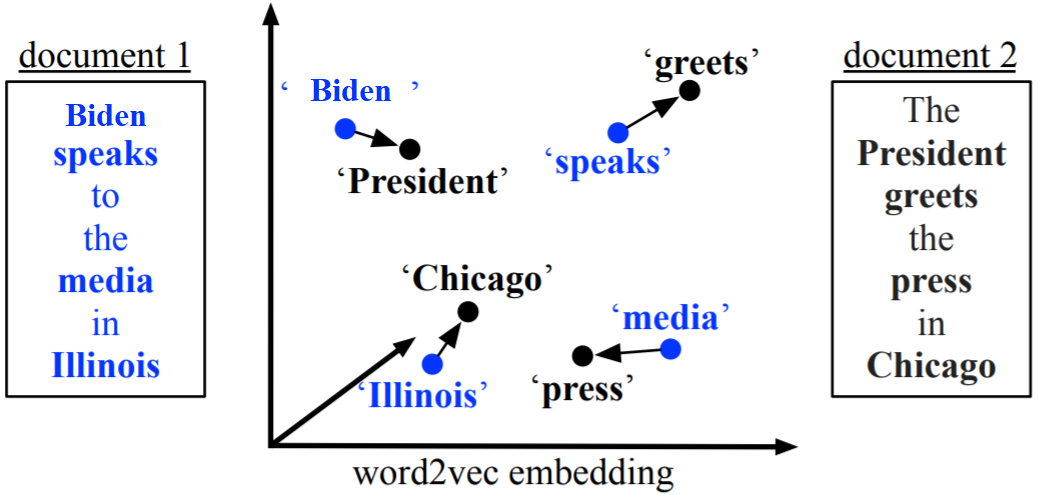

A text document is represented as a vector d, in which each element denotes a word’s normalized frequency in the document, i.e.
$$\begin{aligned}
    \mathbf{d} &=\left[d_{1,} d_{2}, \ldots, d_{n}\right]^{T}, \text { where } \\
    d_{i} &=\frac{c_{i}}{\sum_{j}^{n} c_{j}}, \\
    c_{i} &=\{\text {word }i \text{ appears citimes in a given document}\}
\end{aligned}$$

The Euclidean distance in embedding space of two given words, $\mathbf{x}_i$ and $\mathbf{x}_j$, is defined as follows:
\begin{equation}
    c(i,j) = ||\mathbf{x}_i - \mathbf{x}_j||^2
\end{equation}


In WMD, $\mathbf{x}_i$ and $\mathbf{x}_j$ are from different documents, and $c(i, j)$ is the “travel cost” from word $\mathbf{x}_i$ to $\mathbf{x}_j$.
Suppose there are a source document A and a target document B. A flow matrix $T$ is defined. Each element in the flow matrix, $T _{ij}$, denotes how many times of word $i$ (in document A) transforms into word $j$ (in document B), then normalize the value by the total count of words in the vocabulary. That is to say,
$$\sum_i T_{ij} = d_i\\
\sum_j T_{ij} = d_j$$

Therefore, the semantic distance definition is as follows:
$$
\text { distance }=\min _{\mathbf{T} \geqslant 0} \sum_{i, j=1}^{n} T_{i, j} c(i, j)
$$
By tuning values in $T$, the semantic distance between two documents can be obtained. The distance also is the minimum cumulative cost required to move all words from one document to the other.

In [22]:
docLabels_1 = [f for f in listdir("data/statements") if f.endswith('.txt')]
docLabels_2 = [f for f in listdir("data/minutes") if f.endswith('.txt') and f.strip('FOMC_') in docLabels_1]

In [23]:
data_1 = [
    TaggedDocument(get_words(open('data/statements/' + doc, 'r', encoding='utf8', errors='ignore').read())[0], [i])
    for i, doc in enumerate(docLabels_1)]
data_2 = [
    TaggedDocument(get_words(open('data/minutes/' + doc, 'r', encoding='utf8', errors='ignore').read())[0], [i + 192])
    for i, doc in enumerate(docLabels_2)]

In [24]:
data = data_1 + data_2

In [25]:
model = Doc2Vec(data, vector_size=50, window=1, min_count=1, workers=12)
fname = get_tmpfile("doc2vec_model")
model.save(fname)

In [26]:
model = Doc2Vec.load(fname)
Distance = []
with open('data\calendars_statements.txt', 'r') as f:
    i = 1
    for l in f.readlines():
        line = l.replace('\n', '')
        #         print('Distance between statements and minutes for the FOMC on date:',pd.to_datetime(line).strftime("%Y-%m-%d"))
        #         print(model.wv.distance(i, i + 192))
        Distance.append(model.wv.wmdistance(
            open('data/minutes/FOMC_' + line + r'.txt', 'r', encoding='utf8', errors='ignore').read().replace(
                '\n', ' ').replace('\xad', ''),
            open('data/statements/' + line + r'.txt', 'r', encoding='utf8', errors='ignore').read().replace(
                '\n', ' ').replace('\xad', '')))
        i += 1
Distance = pd.Series(Distance)

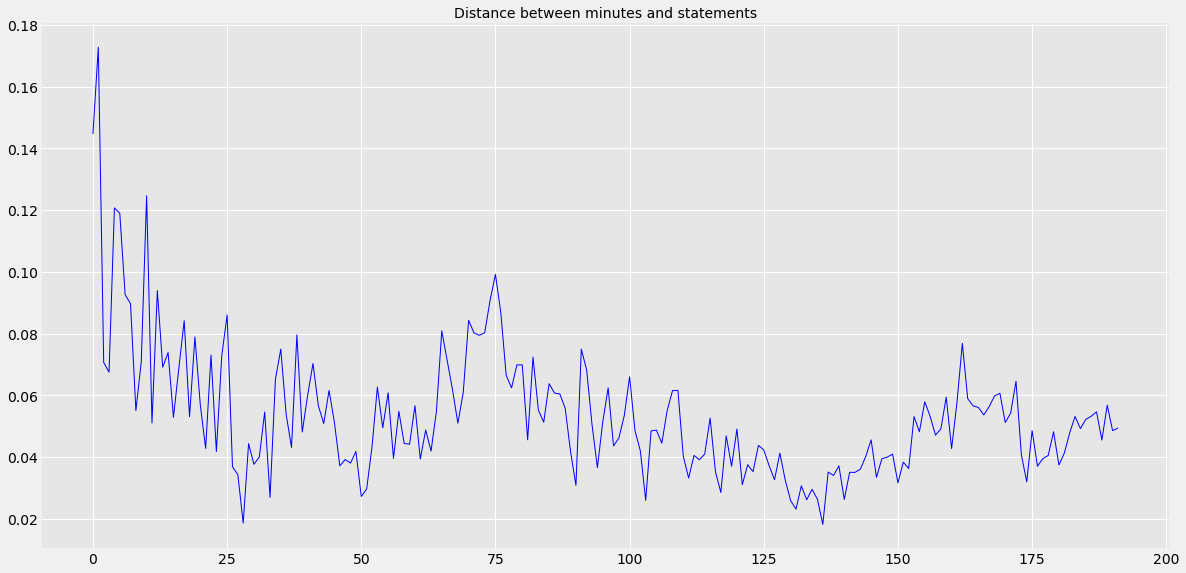

In [27]:
fig, ax = plt.subplots()
ax.plot(df_minutes.index, Distance, c='blue', linewidth=1.0)
plt.title('Distance between minutes and statements', size='medium')
plt.show()

In [28]:
Distance.describe()

count    192.000000
mean       0.053366
std        0.021232
min        0.018165
25%        0.039545
50%        0.049431
75%        0.061539
max        0.172757
dtype: float64

<AxesSubplot:>

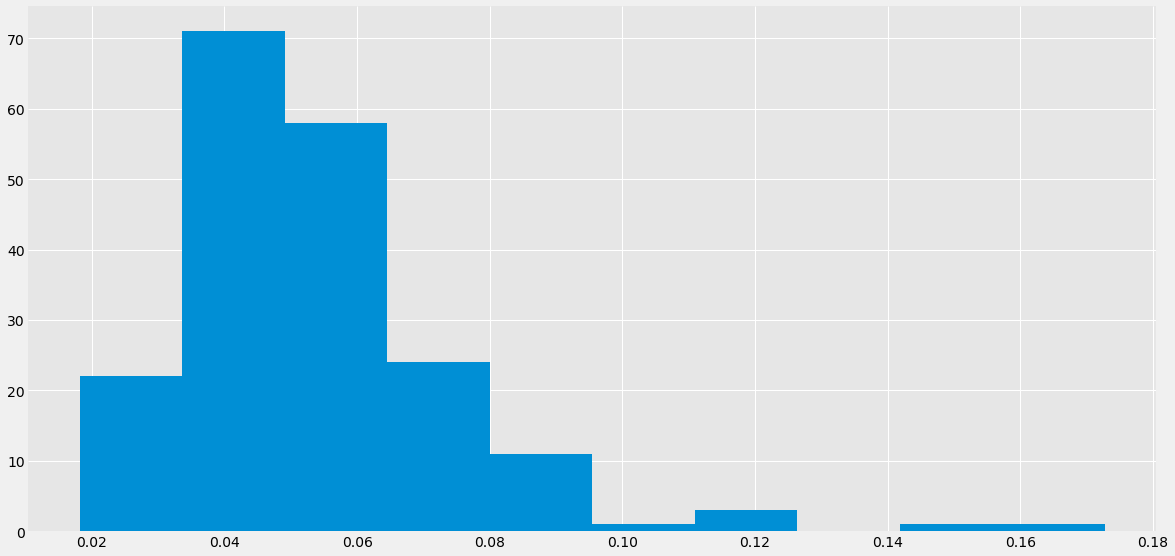

In [29]:
Distance.hist()

## Methodology

### LDA Topic Modeling

A prerequisite for finding trading signal is to understand whether the data we extract contains topics/signals related to market, and more importantly, whether it contains information that we may trade.

This requires us to examine and evaluate the various topics and vocabulary representing these topics in the data. The so-called: garbage in, garbage out.

To explore various topics in the FOMC documents, we will use Gensim’sLatent Dirichlet Allocation(Hidden Dirichlet distribution model). LDA is a generation probability model suitable for discrete data sets such as text. The function of LDA is as a hierarchical Bayesian model, in which each item in the collection is modeled as a finite mixture on the basic theme collection. In turn, each topic is shaped into an infinite mixture of basic topic probabilities.

In LDA model, we need to estimate the number of topics in the dataset through the num_topics hyperparameter. According to models' coherence scores, X is a wise choice.

In [30]:
# # Instantiate model
# model = gs.models.LdaMulticore(dataname, num_topics = X, id2word = tweet_dict, passes = 10, workers = 12)
# # Display topics
# model.show_topics()

In [31]:
# topic_vis = gensimvis.prepare(model, cbow_tweet, tweet_dict)
# pyLDAvis.display(topic_vis)

In [32]:
# pyLDAvis.save_html(topic_vis, 'topic_vis.html')

By examining the final topic map, we can see that the performance of the LDA model on capturing the salient topics and their constituent words in the data is not bad.

In [33]:
# # Compute Coherence Score
# coherence_model = gs.models.CoherenceModel(model=model,texts=tweets_preprocessed,dictionary=tweet_dict,coherence='c_v')
# coherence_score = coherence_model.get_coherence()
# print(f'Coherence Score: {coherence_score}')

The results of Roder, Both and Hindeburg in the paper motivated us to choose the method of score measurement, which can be seen from the signature of the above consistency model logic. You can see that we have chosen the coherence ='c_v metric for the model, instead of'u_mass','c_v', and'c_uci'. We found that the "c_v" scoring standard can achieve better results than other methods, especially when the word set is small, which is in line with our choice. The consensus score of our model is X. We believe our model can be better if we have data with higher quality. Generally, our LDA model has been trained on the correct number of topics and maintains a sufficient degree of semantic similarity between words with higher scores in each topic.

### Sentiment analysis

Here we utilize an common dictionary for textual data analysis in accounting and finance area: [Loughran-McDonald Master Dictionary](https://sraf.nd.edu/textual-analysis/resources/#Master%20Dictionary). Within the dictionary spreadsheet, Tim Loughran and Bill McDonald provide flags for the sentiment dictionaries (e.g., negative, uncertainty, litigious). Additional documentation for each word is also provided such as other classifications (e.g., Harvard TagNeg, constraining), syllabification, and source. 

In [34]:
LM_list = pd.read_excel("LM Word List.xlsx")

In [35]:
word_list = []
for sentiment_class in ["Negative", "Positive", "Uncertainty", "Litigious", "Strong_Modal", "Weak_Modal",
                        "Constraining"]:
    sentiment_list = LM_list[LM_list[sentiment_class] > 0]["Word"].str.lower()
    word_list.append(sentiment_list)
word_list = pd.concat(word_list, axis=1, sort=True).fillna(" ")
word_list.columns = ["Negative", "Positive", "Uncertainty", "Litigious", "Strong_Modal", "Weak_Modal", "Constraining"]
word_list.reset_index(drop=True, inplace=True)
word_list

,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining
0,abandon,,,,,,
1,abandoned,,,,,,
2,abandoning,,,,,,
3,abandonment,,,,,,
4,abandonments,,,,,,
...,...,...,...,...,...,...,...
3854,wrongdoing,,,,,,
3855,wrongdoings,,,,,,
3856,wrongful,,,,,,
3857,wrongfully,,,,,,


In [36]:
word_list = word_list.to_dict('list')  #create a dictionary out of the excel list and use it to map the transcripts
word_list

{'Negative': ['abandon',
  'abandoned',
  'abandoning',
  'abandonment',
  'abandonments',
  'abandons',
  'abdicated',
  'abdicates',
  'abdicating',
  'abdication',
  'abdications',
  'aberrant',
  'aberration',
  'aberrational',
  'aberrations',
  'abetting',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  'abnormal',
  'abnormalities',
  'abnormality',
  'abnormally',
  'abolish',
  'abolished',
  'abolishes',
  'abolishing',
  ' ',
  'abrogate',
  'abrogated',
  'abrogates',
  'abrogating',
  'abrogation',
  'abrogations',
  'abrupt',
  'abruptly',
  'abruptness',
  'absence',
  'absences',
  'absenteeism',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  'abuse',
  'abused',
  'abuses',
  'abusing',
  'abusive',
  'abusively',
  'abusiveness',
  ' ',
  ' ',
  'accident',
  'accidental',
  'accidentally',
  'accidents',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  'accusation',
  'accusations',
  'accuse',
  'accused',
  'accuses',
  'accusing',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  '

In [37]:
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]


def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

In [38]:
def count_with_negation(fin_dict, transcript):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    negation is occurring within three words preceding a positive words.
    """
    pos_count = 0
    neg_count = 0

    pos_words = []
    neg_words = []

    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', transcript.lower())

    word_count = len(input_words)

    for i in range(0, word_count):
        if input_words[i] in fin_dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in fin_dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])

    results = [word_count, pos_count, neg_count, pos_words, neg_words]

    return results

In [39]:
temp = df_statements["statements"].swifter.apply(lambda x: count_with_negation(word_list, x))

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

In [40]:
df_statements

,date,statements,number of words,number of sentences,all_words_statements,top_tokens
0,1994-02-04,Chairman Alan Greenspan announced today that t...,99,5,"[alan, greenspan, announced, today, federal, o...","[(market, 3), (committee, 3), (greenspan, 2), ..."
1,1994-03-22,Chairman Alan Greenspan announced today that t...,39,3,"[alan, greenspan, announced, today, federal, o...","[(market, 2), (increase, 2), (alan, 1), (green..."
2,1994-05-17,The Federal Reserve today announced two action...,164,8,"[federal, reserve, today, announced, actions, ...","[(federal, 5), (reserve, 5), (discount, 3), (r..."
3,1994-08-16,The Federal Reserve announced today the follow...,137,7,"[federal, reserve, announced, today, following...","[(federal, 4), (reserve, 4), (actions, 3), (ec..."
4,1994-11-15,The Federal Reserve Board today approved an in...,142,8,"[federal, reserve, board, today, approved, inc...","[(federal, 5), (reserve, 5), (rate, 5), (disco..."
...,...,...,...,...,...,...
187,2021-03-17,The Federal Reserve is committed to using its ...,482,32,"[federal, reserve, committed, range, tools, su...","[(inflation, 10), (committee, 10), (percent, 8..."
188,2021-04-28,The Federal Reserve is committed to using its ...,478,33,"[federal, reserve, committed, range, tools, su...","[(committee, 10), (inflation, 9), (percent, 7)..."
189,2021-06-16,The Federal Reserve is committed to using its ...,476,33,"[federal, reserve, committed, range, tools, su...","[(committee, 10), (inflation, 9), (percent, 7)..."
190,2021-07-28,The Federal Reserve is committed to using its ...,490,33,"[federal, reserve, committed, range, tools, su...","[(committee, 11), (inflation, 9), (percent, 7)..."


In [41]:
df_statements

,date,statements,number of words,number of sentences,all_words_statements,top_tokens
0,1994-02-04,Chairman Alan Greenspan announced today that t...,99,5,"[alan, greenspan, announced, today, federal, o...","[(market, 3), (committee, 3), (greenspan, 2), ..."
1,1994-03-22,Chairman Alan Greenspan announced today that t...,39,3,"[alan, greenspan, announced, today, federal, o...","[(market, 2), (increase, 2), (alan, 1), (green..."
2,1994-05-17,The Federal Reserve today announced two action...,164,8,"[federal, reserve, today, announced, actions, ...","[(federal, 5), (reserve, 5), (discount, 3), (r..."
3,1994-08-16,The Federal Reserve announced today the follow...,137,7,"[federal, reserve, announced, today, following...","[(federal, 4), (reserve, 4), (actions, 3), (ec..."
4,1994-11-15,The Federal Reserve Board today approved an in...,142,8,"[federal, reserve, board, today, approved, inc...","[(federal, 5), (reserve, 5), (rate, 5), (disco..."
...,...,...,...,...,...,...
187,2021-03-17,The Federal Reserve is committed to using its ...,482,32,"[federal, reserve, committed, range, tools, su...","[(inflation, 10), (committee, 10), (percent, 8..."
188,2021-04-28,The Federal Reserve is committed to using its ...,478,33,"[federal, reserve, committed, range, tools, su...","[(committee, 10), (inflation, 9), (percent, 7)..."
189,2021-06-16,The Federal Reserve is committed to using its ...,476,33,"[federal, reserve, committed, range, tools, su...","[(committee, 10), (inflation, 9), (percent, 7)..."
190,2021-07-28,The Federal Reserve is committed to using its ...,490,33,"[federal, reserve, committed, range, tools, su...","[(committee, 11), (inflation, 9), (percent, 7)..."


In [42]:
temp = pd.DataFrame.from_records(temp)
df_statements = pd.concat([df_statements, temp], axis=1, ignore_index=True)
df_statements.columns = ['date', 'statements', 'number of words', 'number of sentences', 'all_words_statements',
                         'top_tokens',
                         'wordcount', 'NPositiveWords', 'NNegativeWords', 'Poswords', 'Negwords']
df_statements.set_index('date', inplace=True)
df_statements

,statements,number of words,number of sentences,all_words_statements,top_tokens,wordcount,NPositiveWords,NNegativeWords,Poswords,Negwords
date,,,,,,,,,,
1994-02-04,Chairman Alan Greenspan announced today that t...,99,5,"[alan, greenspan, announced, today, federal, o...","[(market, 3), (committee, 3), (greenspan, 2), ...",99,1,1,[enhance],[misunderstanding]
1994-03-22,Chairman Alan Greenspan announced today that t...,39,3,"[alan, greenspan, announced, today, federal, o...","[(market, 2), (increase, 2), (alan, 1), (green...",40,0,0,[],[]
1994-05-17,The Federal Reserve today announced two action...,164,8,"[federal, reserve, today, announced, actions, ...","[(federal, 5), (reserve, 5), (discount, 3), (r...",160,1,0,[favorable],[]
1994-08-16,The Federal Reserve announced today the follow...,137,7,"[federal, reserve, announced, today, following...","[(federal, 4), (reserve, 4), (actions, 3), (ec...",137,1,1,[strength],[against]
1994-11-15,The Federal Reserve Board today approved an in...,142,8,"[federal, reserve, board, today, approved, inc...","[(federal, 5), (reserve, 5), (rate, 5), (disco...",139,1,2,[strength],"[against, persistent]"
...,...,...,...,...,...,...,...,...,...,...
2021-03-17,The Federal Reserve is committed to using its ...,482,32,"[federal, reserve, committed, range, tools, su...","[(inflation, 10), (committee, 10), (percent, 8...",474,10,8,"[stability, tremendous, progress, achieve, ach...","[challenging, hardship, adversely, weak, crisi..."
2021-04-28,The Federal Reserve is committed to using its ...,478,33,"[federal, reserve, committed, range, tools, su...","[(committee, 10), (inflation, 9), (percent, 7)...",471,14,7,"[stability, tremendous, progress, strong, stre...","[challenging, hardship, adversely, weak, crisi..."
2021-06-16,The Federal Reserve is committed to using its ...,476,33,"[federal, reserve, committed, range, tools, su...","[(committee, 10), (inflation, 9), (percent, 7)...",469,14,6,"[stability, progress, progress, strong, streng...","[challenging, adversely, weak, crisis, persist..."


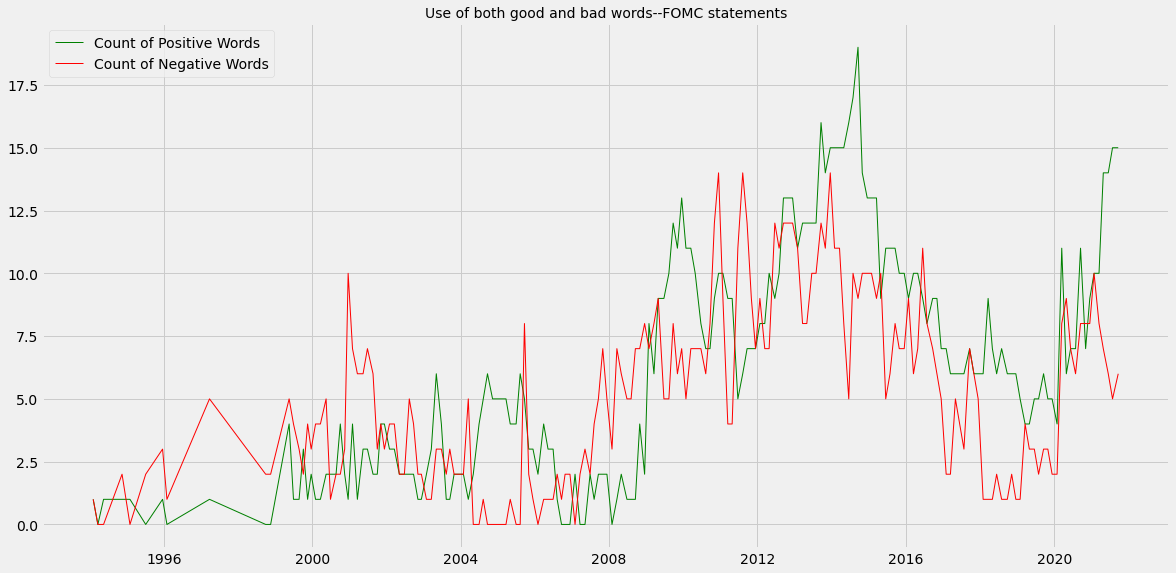

In [43]:
plt.rcParams["figure.figsize"] = (18, 9)
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
ax.plot(df_statements.index, df_statements['NPositiveWords'], c='green', linewidth=1.0)
plt.plot(df_statements.index, df_statements['NNegativeWords'], c='red', linewidth=1.0)
plt.title('Use of both good and bad words--FOMC statements', size='medium')
plt.legend(['Count of Positive Words', 'Count of Negative Words'], prop={'size': 'medium'}, loc=2)

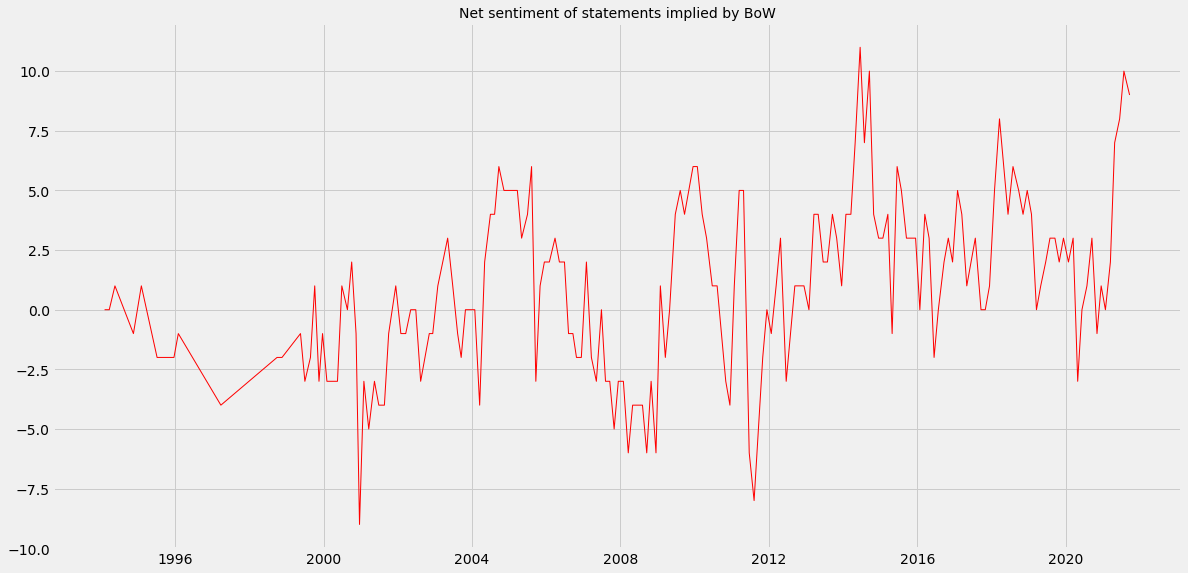

In [44]:
NetSentiment = (df_statements['NPositiveWords'] - df_statements['NNegativeWords'])
fig, ax = plt.subplots()
ax.plot(df_statements.index, NetSentiment, c='red', linewidth=1.0)
plt.title('Net sentiment of statements implied by BoW', size='medium')
plt.show()

In [45]:
temp = df_minutes["minutes"].swifter.apply(lambda x: count_with_negation(word_list, x))

Pandas Apply:   0%|          | 0/192 [00:00<?, ?it/s]

In [46]:
temp = pd.DataFrame.from_records(temp)
df_minutes = pd.concat([df_minutes, temp], axis=1, ignore_index=True)
df_minutes.columns = ['date', 'minutes', 'number of words', 'number of sentences', 'all_words_statements',
                      'top_tokens', 'wordcount', 'NPositiveWords', 'NNegativeWords', 'Poswords', 'Negwords']
df_minutes.set_index('date', inplace=True)
df_minutes

,minutes,number of words,number of sentences,all_words_statements,top_tokens,wordcount,NPositiveWords,NNegativeWords,Poswords,Negwords
date,,,,,,,,,,
1994-02-04,The information reviewed at this meeting indic...,6338,233,"[information, reviewed, meeting, indicated, ec...","[(growth, 56), (committee, 47), (economic, 40)...",6246,92,97,"[strong, gains, strengthened, strengthening, g...","[complicated, problems, adverse, severe, unemp..."
1994-03-22,The information reviewed at this meeting indic...,4699,173,"[information, reviewed, meeting, indicated, ec...","[(policy, 35), (members, 35), (february, 33), ...",4674,59,105,"[despite, strong, gain, rebounded, despite, hi...","[severe, adverse, declined, declined, vulnerab..."
1994-05-17,The information reviewed at this meeting sugge...,4450,163,"[information, reviewed, meeting, suggested, ec...","[(growth, 29), (april, 27), (prices, 25), (pol...",4434,65,104,"[favorable, stronger, gains, strong, rebound, ...","[sharply, severe, losses, slower, unemployment..."
1994-08-16,The information reviewed at this meeting sugge...,4316,164,"[information, reviewed, meeting, suggested, pa...","[(growth, 38), (july, 26), (quarter, 26), (mem...",4300,47,79,"[gains, favorable, strong, gain, despite, popu...","[slowed, volatile, unemployment, decline, slow..."
1994-11-15,The information reviewed at this meeting sugge...,4467,164,"[information, reviewed, meeting, suggested, gr...","[(growth, 33), (policy, 26), (business, 24), (...",4463,61,66,"[strong, despite, strong, gains, gains, advanc...","[tightening, slowed, unemployment, declined, p..."
...,...,...,...,...,...,...,...,...,...,...
2021-03-17,Staff Review of the Economic Situation The COV...,6033,252,"[staff, review, economic, situation, covid, pa...","[(participants, 54), (inflation, 51), (january...",6048,94,107,"[improved, gains, boosted, stronger, gain, boo...","[losses, unemployment, unemployment, declined,..."
2021-04-28,Staff Review of the Economic Situation The COV...,5518,244,"[staff, review, economic, situation, covid, pa...","[(participants, 51), (inflation, 44), (remaine...",5539,92,121,"[improved, gain, exceptionally, boosted, boost...","[losses, unemployment, declined, layoff, layof..."
2021-06-16,Staff Review of the Economic Situation The inf...,5978,251,"[staff, review, economic, situation, informati...","[(inflation, 65), (participants, 65), (economi...",6006,97,104,"[improved, gains, gains, boosted, stronger, ga...","[slower, losses, unemployment, unemployment, c..."


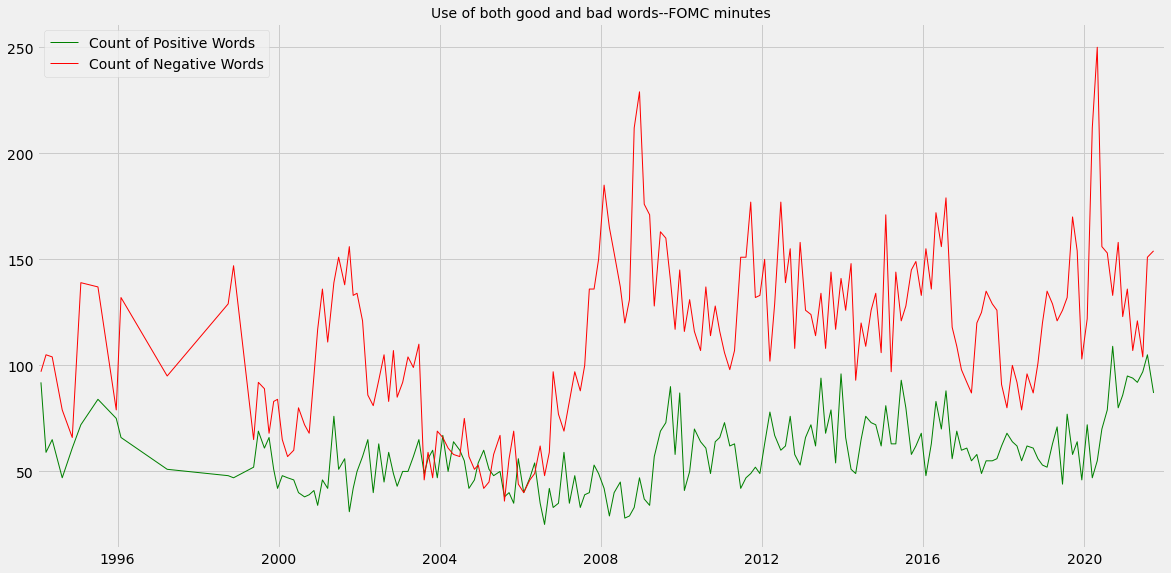

In [47]:
plt.rcParams["figure.figsize"] = (18, 9)
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
ax.plot(df_minutes.index, df_minutes['NPositiveWords'], c='green', linewidth=1.0)
plt.plot(df_minutes.index, df_minutes['NNegativeWords'], c='red', linewidth=1.0)
plt.title('Use of both good and bad words--FOMC minutes', size='medium')
plt.legend(['Count of Positive Words', 'Count of Negative Words'], prop={'size': 'medium'}, loc=2)

years = mdates.YearLocator()  # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

datemin = np.datetime64(df_minutes.index[0], 'Y')
datemax = np.datetime64(df_minutes.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)
# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.savefig('fomc_correlated_words_minutes.png', dpi=60, bbox_inches="tight")
plt.show()

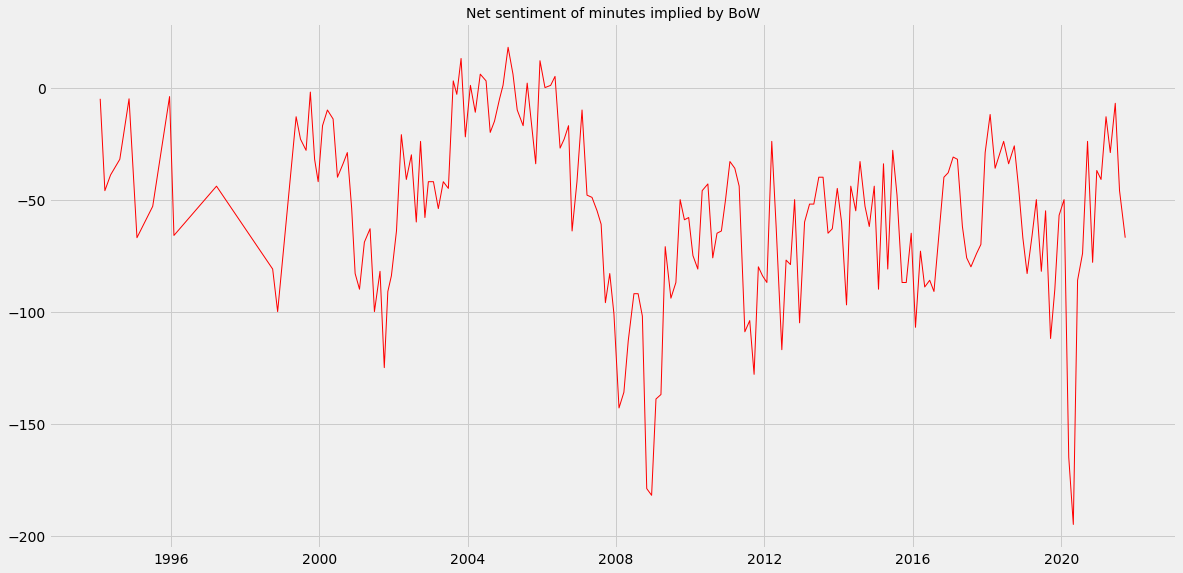

In [48]:
NetSentiment = (df_minutes['NPositiveWords'] - df_minutes['NNegativeWords'])
fig, ax = plt.subplots()
ax.plot(df_minutes.index, NetSentiment, c='red', linewidth=1.0)
plt.title('Net sentiment of minutes implied by BoW', size='medium')
plt.show()

### Traing signal contained in minutes

We select three indexes to skecth the effect of the FOMC's documents on the market: S&P 500 Index(SPY), Treasury Yield 10 Years (TNX), CBOE Volatility Index (VIX). The data is from [Yahoo Finance](https://finance.yahoo.com/)

In [49]:
spy_df = pd.read_csv('./data/SPY.csv')
spy_df.fillna(method='pad')
spy_df["SPY"] = spy_df["Adj Close"].pct_change() * 100
spy_df.drop(columns=["Open", 'High', 'Low', 'Close', "Adj Close", 'Volume'], inplace=True)
spy_df.drop(0, inplace=True)
vix_df = pd.read_csv('./data/^VIX.csv')
vix_df.fillna(method='pad')
vix_df["VIX"] = vix_df["Adj Close"].pct_change() * 100
vix_df.drop(columns=["Open", 'High', 'Low', 'Close', "Adj Close", 'Volume'], inplace=True)
vix_df.drop(0, inplace=True)
tnx_df = pd.read_csv('./data/^TNX.csv')
tnx_df.fillna(method='pad')
tnx_df["TNX"] = tnx_df["Adj Close"].pct_change() * 100
tnx_df.drop(columns=["Open", 'High', 'Low', 'Close', "Adj Close", 'Volume'], inplace=True)
tnx_df.drop(0, inplace=True)

In [50]:
mkt_df = pd.merge(spy_df, vix_df, how='left', on='Date')
mkt_df = pd.merge(mkt_df, tnx_df, how='left', on='Date')
mkt_df.set_index('Date', inplace=True)
mkt_df

,SPY,VIX,TNX
Date,,,
1993-02-01,0.711301,-0.724638,-0.156495
1993-02-02,0.211824,-0.648824,1.253918
1993-02-03,1.057069,-1.061224,-0.154799
1993-02-04,0.418402,1.402640,-0.930233
1993-02-05,-0.069410,4.963385,-1.095462
...,...,...,...
2021-11-01,0.172022,0.922509,1.156069
2021-11-02,0.404309,-2.315655,-1.650794
2021-11-03,0.610523,-5.801628,1.936733


##  Conclusion and Further work

## Reference

1. Kusner, M., Sun, Y., Kolkin, N., & Weinberger, K. (2015, June). From word embeddings to document distances. In International conference on machine learning (pp. 957-966). PMLR.
2. Loughran, T., & McDonald, B. (2020). Measuring firm complexity. Available at SSRN 3645372.
3. Röder, M., Both, A., & Hinneburg, A. (2015, February). Exploring the space of topic coherence measures. In Proceedings of the eighth ACM international conference on Web search and data mining (pp. 399-408).
4. Sievert, C., & Shirley, K. (2014, June). LDAvis: A method for visualizing and interpreting topics. In Proceedings of the workshop on interactive language learning, visualization, and interfaces (pp. 63-70).